# SIGMORPHON 2018 - Hungarian data analysis

In [52]:
import pandas as pd
from collections import defaultdict
import subprocess
import matplotlib.pyplot as plt

In [38]:
model = "../../../../repo/emMorph/hfst/hu.hfstol"

def parse_hfst_output(output):
    all_ana = []
    word = None
    for line in output.split("\n"):
        if line.strip():
            word, ana = line.strip().split("\t")[:2]
            all_ana.append(ana)
        else:
            if all_ana:
                yield word, all_ana
            all_ana = []
    if all_ana:
        yield word, all_ana
        
def run_hfst_ana(words):
    p = subprocess.Popen("hfst-lookup {} --cascade=composition".format(model),
                         stdin=subprocess.PIPE, stdout=subprocess.PIPE,
                         stderr=subprocess.PIPE, shell=True)
    stdout = p.communicate("\n".join(words).encode("utf8"))[0]
    hfst_output = {}
    not_found = set()
    for word, ana in parse_hfst_output(stdout.decode("utf8")):
        hfst_output[word] = ana
    return hfst_output

# Load data into DataFrames and run HFST

In [39]:
hun_train = pd.read_table("../../data/conll2018/task1/all/hungarian-train-high", names=["lemma", "word", "tags"])
hun_dev = pd.read_table("../../data/conll2018/task1/all/hungarian-dev", names=["lemma", "word", "tags"])
hun = pd.concat((hun_train, hun_dev))
hun = hun.reset_index(drop=True)
hun = pd.read_table("/mnt/permanent/home/judit/repo/external/unimorph_hun/hun", names=["lemma", "word", "tags"])

### Replace `singular` with the lemma

Nominal case is unmarked in Hungarian.

In [40]:
hun.loc[hun['word'] == 'singular', 'word'] = hun['lemma']
ana = pd.Series(run_hfst_ana(hun["word"])).to_frame()
hun = hun.merge(ana, left_on="word", right_index=True)
hun = hun.rename(columns={0: "hfst"})
hun.head()

,lemma,word,tags,hfst
0,gravitáció,gravitáción,N;ON+ESS;SG,[gravitáció[/N]n[Supe]]
1,gravitáció,gravitációként,N;FRML;SG,[gravitáció[/N]ként[EssFor:ként]]
2,gravitáció,gravitációkban,N;IN+ESS;PL,[gravitáció[/N]k[Pl]ban[Ine]]
3,gravitáció,gravitációkhoz,N;AT+ALL;PL,[gravitáció[/N]k[Pl]hoz[All]]
4,gravitáció,gravitáció,N;NOM;SG,[gravitáció[/N][Nom]]


In [41]:
hun = hun[~hun.word.str.contains('---')].copy()
hun.head()

,lemma,word,tags,hfst
0,gravitáció,gravitáción,N;ON+ESS;SG,[gravitáció[/N]n[Supe]]
1,gravitáció,gravitációként,N;FRML;SG,[gravitáció[/N]ként[EssFor:ként]]
2,gravitáció,gravitációkban,N;IN+ESS;PL,[gravitáció[/N]k[Pl]ban[Ine]]
3,gravitáció,gravitációkhoz,N;AT+ALL;PL,[gravitáció[/N]k[Pl]hoz[All]]
4,gravitáció,gravitáció,N;NOM;SG,[gravitáció[/N][Nom]]


## HFST fail cases

HFST prints `+?` if it cannot analyze a word form.

In [42]:
def does_hfst_fail(ana):
    return "+?" in ana[0]

hun["hfst_no_ana"] = hun["hfst"].apply(does_hfst_fail)
print("Couldn't analyze {} words".format(hun["hfst_no_ana"].sum()))

Couldn't analyze 20057 words


## POS

Just because we can.

In [43]:
hun["pos"] = hun["tags"].apply(lambda s: s.split(";")[0])
hun["pos"].value_counts()

N         429393
V          99568
V.PTCP      5626
V.CVB       2098
Name: pos, dtype: int64

## Matching Unimorph tags with one of HFST's outputs

Here I'm trying to find the best match out of HFST's multiple outputs (usually 1-5 options). All Unimorph tags are being tested against the candidates.

In [44]:
noun_case_mapping = {
    "AT+ABL": "[Abl]",
    "AT+ALL": "[All]",
    "AT+ESS": "[Ade]",
    "IN+ABL": "[Ela]",
    "IN+ALL": "[Ill]",
    "IN+ESS": "[Ine]",
    "ON+ABL": "[Del]",
    "ON+ALL": "[Subl]",
    "ON+ESS": "[Supe]",
    "INST": "[Ins]",
    "PRP": "[Cau]",
    "TRANS": "[Transl]",
    "TERM": "[Ter]",
    "DAT": "[Dat]",
    "ACC": "[Acc]",
    "NOM": "[Nom]",
    "FRML": "[EssFor:ként]",
}

tag_mapping = {
    "V": "/V",
    "COND": "[Cond",
    "DEF": "Def",
    "1": ".1",
    "2": ".2",
    "3": ".3",
    "FUT": "Fut",
    "SBJV": "Sbjv",
    "V.CVB": "[_AdvPtcp/Adv]",
    "V.PTCP": "Ptcp",
    "INDF": ".NDef.",
    "NFIN": "[Inf",
}

def substr_match(s):
    def is_in(hfst_ana, tags):
        return s in hfst_ana
    return is_in


correct_func = {
    key: substr_match(value) for key, value in noun_case_mapping.items()
}

correct_func.update({
    key: substr_match(value) for key, value in tag_mapping.items()
})

def correct_singular(hfst_ana, sigm_tags):
    if sigm_tags[0] == "N":
        return "[Pl" not in hfst_ana
    return "Sg" in hfst_ana
    
    
def correct_plural(hfst_ana, sigm_tags):
    if sigm_tags[0] == "N":
        return "[Pl]" in hfst_ana
    return "Pl" in hfst_ana
    
    
def past_correct(hfst_ana, sigm_tags):
    if sigm_tags[0] == 'V.PTCP':
        return 'Fut' not in hfst_ana
    return '[Pst' in hfst_ana


correct_func['SG'] = correct_singular
correct_func['PL'] = correct_plural
correct_func['N'] = lambda hfst_ana, tags: ('/N' in hfst_ana or '/Adj' in hfst_ana)
correct_func['PRS'] = lambda hfst_ana, tags: ('[Pst' not in hfst_ana)
correct_func['PST'] = past_correct

correct_func['IND'] = lambda hfst_ana, tags: ('Sbjv' not in hfst_ana)

def disambig_ana(row, verbose=False):
    tags = row['tags'].split(';')
    correct = []
    for ana in row['hfst']:
        ok = {}
        for tag in tags:
            ok[tag] = correct_func[tag](ana, tags)
        if verbose:
            print(ana, ok)
        if all(ok.values()):
            correct.append(ana)
    if len(correct) > 0:
        row['correct_ana'] = correct[0]
    else:
        row['correct_ana'] = None
    return row
   

In [45]:
hun = hun.apply(disambig_ana, axis=1)
hun.head()

,lemma,word,tags,hfst,hfst_no_ana,pos,correct_ana
0,gravitáció,gravitáción,N;ON+ESS;SG,[gravitáció[/N]n[Supe]],False,N,gravitáció[/N]n[Supe]
1,gravitáció,gravitációként,N;FRML;SG,[gravitáció[/N]ként[EssFor:ként]],False,N,gravitáció[/N]ként[EssFor:ként]
2,gravitáció,gravitációkban,N;IN+ESS;PL,[gravitáció[/N]k[Pl]ban[Ine]],False,N,gravitáció[/N]k[Pl]ban[Ine]
3,gravitáció,gravitációkhoz,N;AT+ALL;PL,[gravitáció[/N]k[Pl]hoz[All]],False,N,gravitáció[/N]k[Pl]hoz[All]
4,gravitáció,gravitáció,N;NOM;SG,[gravitáció[/N][Nom]],False,N,gravitáció[/N][Nom]


## Failed cases

HFST is able to analyze the word but I could not match it with Unimorph tags.

In [46]:
no_correct = hun[(hun['correct_ana'].isnull()) & (hun['hfst_no_ana'] == False)].copy()
print("Unable to match {} out of {}".format(len(no_correct), len(hun)))

Unable to match 4187 out of 536685


In [47]:
no_correct.head()

,lemma,word,tags,hfst,hfst_no_ana,pos,correct_ana
1012,gyalogjaim,gyalogjaimnál,N;AT+ESS;SG,[gyalog[/N]jaim[Pl.Poss.1Sg]nál[Ade]],False,N,None
1013,gyalogjaim,gyalogjaimon,N;ON+ESS;SG,[gyalog[/N]jaim[Pl.Poss.1Sg]on[Supe]],False,N,None
1014,gyalogjaim,gyalogjaimként,N;FRML;SG,[gyalog[/N]jaim[Pl.Poss.1Sg]ként[EssFor:ként]],False,N,None
1015,gyalogjaim,gyalogjaimmá,N;TRANS;SG,[gyalog[/N]jaim[Pl.Poss.1Sg]má[Transl]],False,N,None
1016,gyalogjaim,gyalogjaimig,N;TERM;SG,[gyalog[/N]jaim[Pl.Poss.1Sg]ig[Ter]],False,N,None


### All of them are nouns

The single verb is actually an error by HFST.

In [48]:
no_correct['pos'].value_counts()

N         4141
V           37
V.PTCP       8
V.CVB        1
Name: pos, dtype: int64

## Incorrect noun cases

I look for noun case mismatches.

In [90]:
inv_case_mapping = {v: k for k, v in noun_case_mapping.items()}

confusion_matrix = defaultdict(lambda: defaultdict(int))

def noun_case_incorrect(row):
    tags = row['tags'].split(';')
    row['noun_case_incorrect'] = False
    if tags[0] != 'N':
        return row
    else:
        case = tags[1]
        hfst_case = noun_case_mapping[case]
        if row['correct_ana'] is not None:
            assert hfst_case in row['correct_ana']
            row['noun_case_incorrect'] = False
        else:
            found = False
            for ana in row['hfst']:
                if hfst_case in ana:
                    row['noun_case_incorrect'] = False
                    found = True
                    break
            if found is False:
                for other_case in noun_case_mapping.values():
                    if other_case == hfst_case:
                        confusion_matrix[inv_case_mapping[other_case]][case] += 1
                        continue
                    if any(other_case in ana for ana in row['hfst']):
                        confusion_matrix[inv_case_mapping[other_case]][case] += 1
                        row['correct_case'] = inv_case_mapping[other_case]
                        row['noun_case_incorrect'] = True
                        break
    return row

hun = hun.apply(noun_case_incorrect, axis=1)

### Incorrect noun cases

Listing unanalyzed words as well.

In [91]:
hun[hun.pos=='N'].groupby(['noun_case_incorrect', 'hfst_no_ana']).size().to_frame()

0
noun_case_incorrect hfst_no_ana        
False               False        420380
                    True           8601
True                False           412

### Confusion matrix

It's clear that there is a misalignment.

In [92]:
conf_df = pd.DataFrame(confusion_matrix).fillna(0).astype(int)
conf_df

,ACC,AT+ABL,AT+ALL,AT+ESS,DAT,FRML,IN+ABL,IN+ALL,IN+ESS,INST,NOM,ON+ABL,ON+ALL,ON+ESS,PRP,TERM,TRANS
ACC,668,0,0,0,12,0,0,0,0,0,10,0,0,0,1,0,0
AT+ABL,0,516,0,0,0,0,0,0,0,0,19,8,0,0,0,0,0
AT+ALL,0,0,535,0,0,0,12,0,0,0,5,0,8,0,0,0,0
AT+ESS,0,0,0,522,0,0,0,12,0,0,2,0,0,8,0,0,0
DAT,8,0,0,0,510,0,0,0,0,12,2,0,0,0,0,0,0
FRML,4,0,0,0,0,489,0,0,0,0,3,0,0,0,0,8,0
IN+ABL,0,0,8,0,0,0,518,0,0,0,3,12,0,0,0,0,0
IN+ALL,0,0,0,8,0,0,0,520,0,0,9,0,12,0,0,0,0
IN+ESS,0,0,0,0,0,0,0,0,520,0,3,0,0,11,0,0,0
INST,0,0,0,0,8,0,0,0,0,532,5,0,0,0,12,0,0


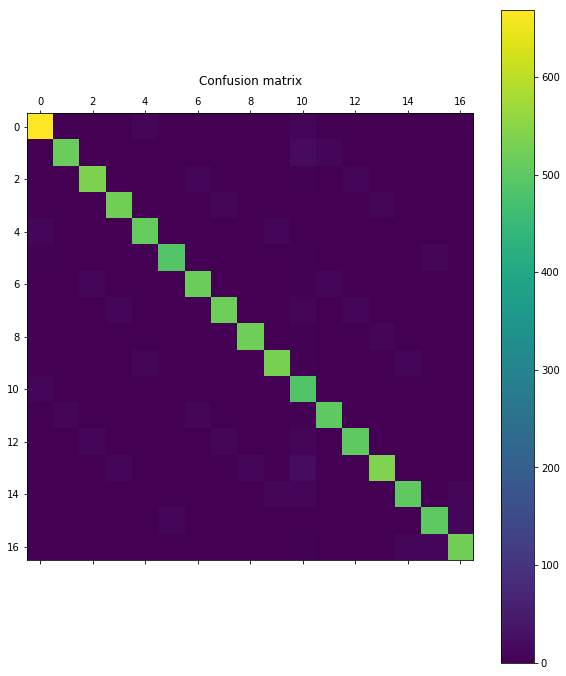

In [93]:
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111)
ax.set_title("Confusion matrix")
cax = ax.matshow(conf_df)
#ax.grid(linewidth=.2)
fig.colorbar(cax)

## Incorrect number in nouns

In [94]:
def noun_number_incorrect(row):
    tags = row['tags'].split(';')
    if tags[0] != 'N':
        row['noun_number_incorrect'] = False
    else:
        number = tags[2]
        if row['correct_ana'] is not None:
            row['noun_number_incorrect'] = False
        else:
            if number == "SG":
                row['noun_number_incorrect'] = not any(correct_singular(ana, tags) for ana in row['hfst'])
            if number == "PL":
                row['noun_number_incorrect'] = not any(correct_plural(ana, tags) for ana in row['hfst'])
    return row

In [95]:
hun = hun.apply(noun_number_incorrect, axis=1)
nouns = hun[hun.pos=='N']
nouns['noun_number_incorrect'].sum(), len(nouns)

(8727, 429393)

In [117]:
incorrect_case = hun[(hun.noun_case_incorrect==True) & (hun.hfst_no_ana==False)]
incorrect_case[['lemma', 'word', 'tags', 'correct_case']].sort_values('lemma').to_csv(
    '/tmp/judit/noun_case_incorrect', index=False, header=False, sep='\t')
len(incorrect_case)

412

In [118]:
incorrect_number = hun[(hun.noun_number_incorrect==True) & (hun.hfst_no_ana==False)]
incorrect_number.sample(10)[['word', 'lemma', 'tags', 'hfst']]

len(incorrect_number)

3755

In [96]:
incorrect = hun[(hun.noun_case_incorrect == True) | (hun.noun_number_incorrect == True)]
incorrect[['lemma', 'word', 'tags', 'correct_case', 'noun_number_incorrect', 'noun_case_incorrect']]

,lemma,word,tags,correct_case,noun_number_incorrect,noun_case_incorrect
1012,gyalogjaim,gyalogjaimnál,N;AT+ESS;SG,NaN,True,False
1013,gyalogjaim,gyalogjaimon,N;ON+ESS;SG,NaN,True,False
1014,gyalogjaim,gyalogjaimként,N;FRML;SG,NaN,True,False
1015,gyalogjaim,gyalogjaimmá,N;TRANS;SG,NaN,True,False
1016,gyalogjaim,gyalogjaimig,N;TERM;SG,NaN,True,False
1017,gyalogjaim,gyalogjaimért,N;PRP;SG,NaN,True,False
1018,gyalogjaim,gyalogjaimat,N;ACC;SG,NaN,True,False
1019,gyalogjaim,gyalogjaimból,N;IN+ABL;SG,NaN,True,False
1020,gyalogjaim,gyalogjaim,N;NOM;SG,NaN,True,False
1021,gyalogjaim,gyalogjaimra,N;ON+ALL;SG,NaN,True,False


## Error co-occurence matrix

In [98]:
hun[hun.pos=='N'].groupby(['noun_number_incorrect', 'noun_case_incorrect']).size().to_frame()

0
noun_number_incorrect noun_case_incorrect        
False                 False                420310
                      True                    356
True                  False                  8671
                      True                     56

## Other errors

These two errors cover all errors (excluding words not analyzed by HFST). The only one left is the incorrect verb.

In [89]:
has_ana = hun[hun.hfst_no_ana == False]
has_ana.correct_ana

has_ana[(has_ana.noun_number_incorrect == False) & (has_ana.noun_case_incorrect == False)
        & (has_ana.correct_ana.isnull())]

,correct_ana,correct_case,hfst,hfst_no_ana,lemma,noun_case_incorrect,noun_number_incorrect,pos,tags,word
56751,None,NaN,"[jön[/V]ő[_ImpfPtcp/Adj][Nom], jövő[/Adj][Nom]...",False,jő,False,False,V.PTCP,V.PTCP;FUT,jövő
56739,None,NaN,[jő[/V]ni[Inf]],False,jő,False,False,V.PTCP,V.PTCP;PST,jőni
61934,None,NaN,"[kapu[/N]ik[Pl.Poss.3Pl]on[Supe], kapu[/N]ikon...",False,kapuik,False,False,N,N;ON+ESS;SG,kapuikon
61942,None,NaN,"[kapu[/N]ik[Pl.Poss.3Pl]ra[Subl], kapu[/N]ikra...",False,kapuik,False,False,N,N;ON+ALL;SG,kapuikra
109711,None,NaN,"[közel[/Adv]ebb[_Comp/Adv]re[Subl], közel[/Pos...",False,közelebb,False,False,N,N;ON+ALL;SG,közelebbre
109721,None,NaN,"[közel[/Adv]ebb[_Comp/Adv]ről[Del], közel[/Pos...",False,közelebb,False,False,N,N;ON+ABL;SG,közelebbről
122400,None,NaN,"[leg[/Supl]közel[/Adv]ebb[_Comp/Adv]re[Subl], ...",False,legközelebb,False,False,N,N;ON+ALL;SG,legközelebbre
122410,None,NaN,"[leg[/Supl]közel[/Adv]ebb[_Comp/Adv]ről[Del], ...",False,legközelebb,False,False,N,N;ON+ABL;SG,legközelebbről
138295,None,NaN,[létrejötte[/N]ünk[Poss.1Pl][Nom]],False,létrejön,False,False,V,V;IND;PST;INDF;1;PL,létrejöttünk
146587,None,NaN,[meg[/Prev]enged[/V]tet[_Caus/V]ik[Prs.Def.3Pl]],False,megengedtetik,False,False,V,V;IND;PRS;INDF;3;SG,megengedtetik
